In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

In [40]:
# import technology table
def return_technology():
    technology = pd.read_csv(f'./../data/technology.csv')
    return technology

In [41]:
# import calorific values
def return_calorificvalues():
    cal = pd.read_excel(f'./data/fuel.xlsx')
    return cal

In [42]:
# import energy data and return energy consumption (PJ) column
def return_energy_consumption(scenario, cal=return_calorificvalues()):
    energy_consumption = pd.read_excel(f'./../scenarios/data-out/{scenario}/VEEMEIM_QF.xlsx')  
    
    # make a new column for Petajoules based on calorific value
    energy_consumption['EnergyConsumption_PJ'] = 0
    
    for fuelID in cal.FuelID.unique():
               
        # return inds of this fuelID in consumptiondf
        inds = energy_consumption[energy_consumption.FuelID == fuelID].index.tolist()
        
        if inds:
            
            if fuelID != 12:
                # set those inds
                energy_consumption.loc[inds, 'EnergyConsumption_PJ'] = energy_consumption.loc[inds, 'VEEMQF_Value'] * 1e6 * cal[cal.FuelID == fuelID].CalValue_MJ.item() * 1e-9  # * 1e6 because prefix = M, and then * 1e-9 to go from MJ to PJ
            else:
                # for electricity consumption is in GWh so *1e9
                energy_consumption.loc[inds, 'EnergyConsumption_PJ'] = energy_consumption.loc[inds, 'VEEMQF_Value'] * 1e9 * cal[cal.FuelID == fuelID].CalValue_MJ.item() * 1e-9  # * 1e6 because prefix = M, and then * 1e-9 to go from MJ to PJ
        
    return energy_consumption

In [43]:
years = range(2015, 2051)
scenarios = ['OMOKA', 'ELECTRICDREAMS', 'KUJINAO', 'STREETFIGHTING']

In [44]:
consumption_by_scenario = {}

for scenario in scenarios:
    
    consumption = return_energy_consumption(scenario)
        
    consumption_by_year = {}
    for year in years:
        
        consumption_by_fuel = {}
        for fuelID in consumption.FuelID.unique():
            
            fuel_consumed = consumption[(consumption['Year'] == year) & (consumption['FuelID'] == fuelID)]['VEEMQF_Value'].sum() * 1e6  # litres or kWh
            
            consumption_by_fuel[fuelID] = fuel_consumed
            
        consumption_by_year[year] = consumption_by_fuel
            
    consumption_by_scenario[scenario] = consumption_by_year

In [45]:
chart_data = {}

for scenario in scenarios:
    
    series = []
    for year in years:
        series.append(sum(consumption_by_scenario[scenario][year].values()))
    
    chart_data[scenario] = series
    

In [46]:
chart_data_by_fuel = {}

for scenario in scenarios:
    data_by_fuel = {}
    for fuelID in [1,2,12]:
        
        series = []
        for year in years:
            series.append(consumption_by_scenario[scenario][year][fuelID])
        
        data_by_fuel[fuelID] = series
        
    chart_data_by_fuel[scenario] = data_by_fuel

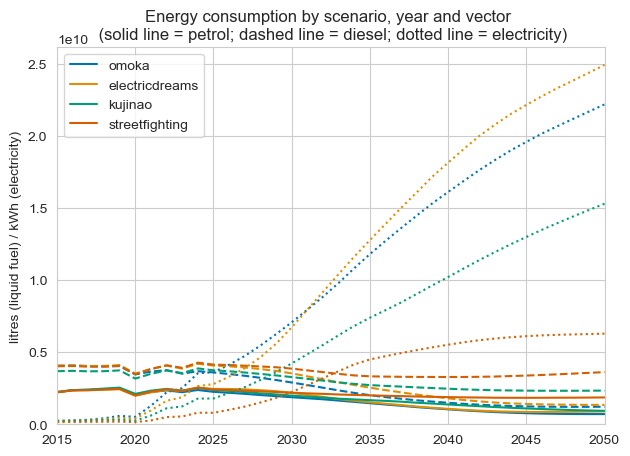

In [47]:
fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')
legend_labels = {'omoka':'Omoka', 'electricdreams': 'Electric Dreams', 'kujinao': 'Kujinao', 'streetfighting': 'Streetfighting'}
lnstls = ['-', '--', ':']

cnt = 0
for scenario in scenarios:
    lnstl_cnt = 0
    
    for fuelID in [1,2,12]:
        if (lnstl_cnt == 0):
            ax.plot(range(2015, 2051), chart_data_by_fuel[scenario][fuelID], color=clrs[cnt], label=scenario.lower(), linestyle=lnstls[lnstl_cnt])
        else:
            ax.plot(range(2015, 2051), chart_data_by_fuel[scenario][fuelID], color=clrs[cnt], linestyle=lnstls[lnstl_cnt])
        
        lnstl_cnt += 1
    cnt += 1
    
ax.legend()
ax.set_ylabel('litres (liquid fuel) / kWh (electricity)')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Energy consumption by scenario, year and vector \n (solid line = petrol; dashed line = diesel; dotted line = electricity)')

fig.tight_layout()
plt.savefig('energy-consumption-by-vector.pdf')

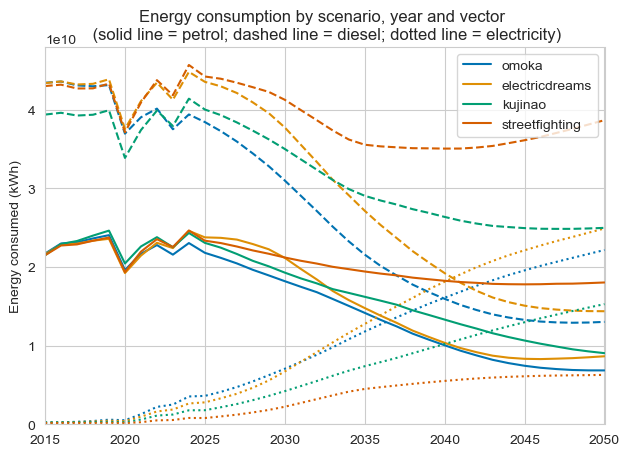

In [48]:
# do it again but in terms of energy (kWh)?

fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

lnstls = ['-','--',':','.-']
cnt = 0
for scenario in scenarios:
    lnstl_cnt = 0
    
    for fuelID in [1,2,12]:
        
        if fuelID == 1:
            chart_data_by_fuel[scenario][fuelID] = [c * 9.7 for c in chart_data_by_fuel[scenario][fuelID]]
        elif fuelID == 2:
            chart_data_by_fuel[scenario][fuelID] = [c * 10.7 for c in chart_data_by_fuel[scenario][fuelID]]
        
        if (lnstl_cnt == 0):
            ax.plot(range(2015, 2051), chart_data_by_fuel[scenario][fuelID], color=clrs[cnt], label=scenario.lower(), linestyle=lnstls[lnstl_cnt])
        else:
            ax.plot(range(2015, 2051), chart_data_by_fuel[scenario][fuelID], color=clrs[cnt], linestyle=lnstls[lnstl_cnt])
        
        lnstl_cnt += 1
    cnt += 1
    
ax.legend()
ax.set_ylabel('Energy consumed (kWh)')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Energy consumption by scenario, year and vector \n (solid line = petrol; dashed line = diesel; dotted line = electricity)')

fig.tight_layout()
plt.savefig('energy-consumption-by-vector-kWh.pdf')

In [49]:
cal = return_calorificvalues()
cal

,FuelID,FuelTypeID,FuelAB,FuelNA,Condition,DenomUnit,Density_kg,CalValue_MJ
0,1,1,GAS,Gasoline,NaN,l,0.74500,32.1840
1,2,1,DIESEL,Diesel,NaN,l,0.83200,35.8600
2,3,1,GAS_IMP,Improved Gasoline,NaN,l,0.74500,32.1840
3,4,1,DIE_IMP,Improved Diesel,NaN,l,0.83200,35.8600
4,5,1,LPG,Liquified Petroleum Gas,NaN,l,0.55000,25.3000
5,6,3,MEOH,Biomethanol,NaN,l,0.79300,15.7800
6,7,3,E85,Bioethanol(85)-petrol(15) blend,NaN,l,0.78700,23.0200
7,8,3,B100,"Biodiesel (FT, synthetic)",NaN,l,0.78000,34.3200
8,10,2,CNG,Compressed Natural Gas,200 bar (20 MPa),l,0.17400,8.3000
9,11,3,CBG,Compressed Bio Gas,200 bar (20 MPa),l,0.17400,8.3000


In [50]:
# return normalised to calorific value
energy_by_scenario = {}

for scenario in scenarios:
    
    consumption = return_energy_consumption(scenario)
        
    energy_by_year = {}
    for year in years:
        
        energy_by_vector = {}
        for fuelID in consumption.FuelID.unique():
            
            fuel_consumed = consumption[(consumption['Year'] == year) & (consumption['FuelID'] == fuelID)]['VEEMQF_Value'].sum() * 1e6  # litres or kWh
            
            # convert to ENERGY (MJ)
            fuel_consumed *= cal[cal.FuelID == fuelID].CalValue_MJ.item() / 1e9 # PJ
            
            energy_by_vector[fuelID] = fuel_consumed
            
        energy_by_year[year] = energy_by_vector
            
    energy_by_scenario[scenario] = energy_by_year

In [51]:
chart_data_total = {}

for scenario in scenarios:
    
    series = []
    for year in years:
        series.append(sum(energy_by_scenario[scenario][year].values()))
    
    chart_data_total[scenario] = series
    

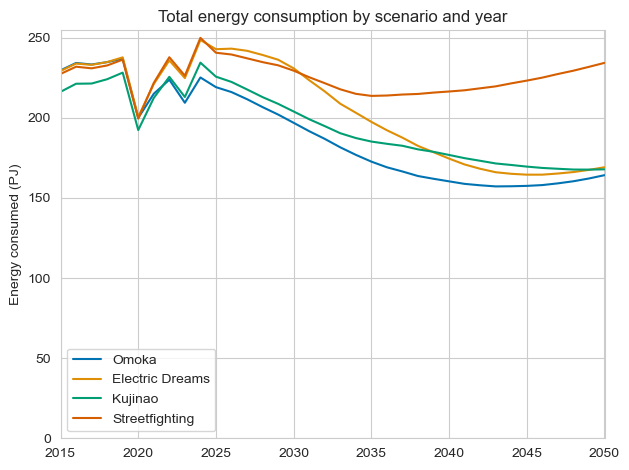

In [52]:
# do it again but in terms of energy MJ for all vectors
legend_labels = {'omoka':'Omoka', 'electricdreams': 'Electric Dreams', 'kujinao': 'Kujinao', 'streetfighting': 'Streetfighting'}

fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

lnstls = ['-','--',':','.-']
cnt = 0
for scenario in scenarios:
    ax.plot(range(2015,2051), chart_data_total[scenario], label=legend_labels[scenario.lower()], color=clrs[cnt])
    cnt+=1
        
ax.legend()
ax.set_ylabel('Energy consumed (PJ)')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Total energy consumption by scenario and year')

fig.tight_layout()
plt.savefig('energy-consumption-by-vector-totalPJ.pdf')

Now do a *STACKED BAR CHART*!!

In [53]:
# dictionary to group fuels, but this time by ID
fuel_groupings = {'Petrol': [1,3], 'Battery Electric': [12], 'Diesel': [2,4], 'Biofuels/Mixes': [6, 7, 8, 11], 'Hydrogen': [13, 14], 'Jet Fuel': [15], 'CNG/LPG':[5, 10]}

# labels for stacked bar chart
labels = ('Baseline 2015',
 'Omoka 2030',
 'Omoka 2040',
 'Omoka 2050',
 'Electric Dreams 2030',
 'Electric Dreams 2040',
 'Electric Dreams 2050',
 'Kujinao 2030',
 'Kujinao 2040',
 'Kujinao 2050',
 'Streetfighting 2030',
 'Streetfighting 2040',
 'Streetfighting 2050')

In [54]:
energy_consumption_dfs = {}
for scenario in scenarios:
    energy_consumption_dfs[scenario] = return_energy_consumption(scenario)

In [55]:
# stacked bar chart!
# group chart data by fuel
chart_data = {}

comparison_years = [2012, 2030, 2040, 2050]

for fuel in fuel_groupings:
    
    data_list = []
    
    for scenario in scenarios:
        
        scenario_consumption = energy_consumption_dfs[scenario]
        
        for year in comparison_years:
            
            if year == 2012:
                if scenario.lower() == 'omoka':
    
                    # append the sum of energy consumption
                    data_list.append(scenario_consumption[(scenario_consumption['Year'] == year) & (scenario_consumption['FuelID'].isin(fuel_groupings[fuel]))]['EnergyConsumption_PJ'].sum())

            else:
                data_list.append(scenario_consumption[(scenario_consumption['Year'] == year) & (scenario_consumption['FuelID'].isin(fuel_groupings[fuel]))]['EnergyConsumption_PJ'].sum())   
                
                    
    chart_data[fuel] = data_list

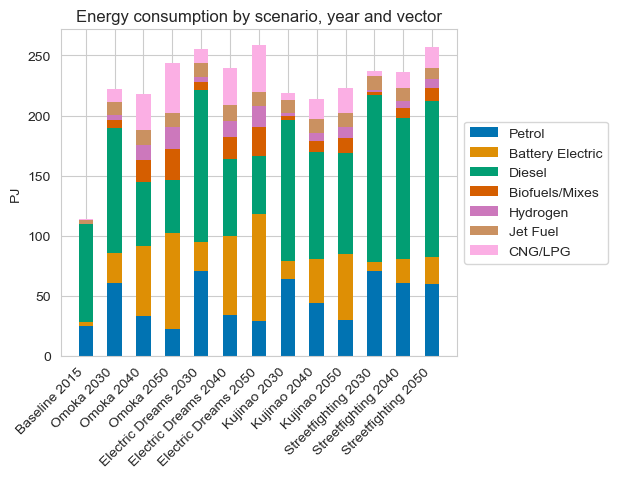

In [56]:
# colour by fuel type
clr_palette = sns.color_palette('colorblind')
clrs = {}
cnt=0
for fuel in fuel_groupings:
    clrs[fuel] = clr_palette[cnt]
    cnt+=1

fig, ax = plt.subplots()

bottom = np.zeros(len(labels))

width = 0.5

for cat in chart_data:
    p = ax.bar(labels, chart_data[cat], width, label=cat, bottom=bottom, color= clrs[cat], linewidth=0)
    bottom += chart_data[cat]
    
fig.autofmt_xdate(rotation=45)

ax.set_title('Energy consumption by scenario, year and vector')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_ylim(top=24)

ax.set_ylabel('PJ')

#fig.tight_layout(w_pad=2)

fig.savefig('total-pj-consumption.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

#plt.savefig('total-pj-consumption.pdf')

In [57]:
# export chart data to csv for report
chart_df = pd.DataFrame(chart_data)
chart_df['Label'] = labels
chart_df = chart_df[['Label']+[c for c in chart_df.columns if c != 'Label']]
chart_df.to_csv('./csv/energy-consumption-by-vector.csv', index=False)